In [1]:
!pip install cmcrameri
!pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [78]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from cmcrameri import cm 
from matplotlib.colors import LogNorm  
from mpl_toolkits.mplot3d import Axes3D

In [79]:
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"
# os.environ["OMP_STACKSIZE"] = "1G"

In [80]:
%%bash
if [[ $(hostname -s) == eiger-* ]]; then
uenv run prgenv-gnu/24.11:v2 --view=default -- make clean
uenv run prgenv-gnu/24.11:v2 --view=default -- make VERSION=kparallel_mpi
else
make clean
make VERSION=kparallel_mpi
fi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/*
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_partitioner.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-kparallel_mpi.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno m_utils.o m_partitioner.o stencil2d-kparallel_mpi.o -o stencil2d-kparallel_mpi.x
cp stencil2d-kparallel_mpi.x stencil2d.x


In [82]:
%%bash 
echo "$(hostname -s)"
if [[ $(hostname -s) == eiger-* ]]; then
    echo "You are on eiger"
fi

nid005084


In [83]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims.txt

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out_eiger.txt
echo "dimensions = [[0.0]*11 for _ in range(73)]" > dims_eiger.txt


for nthreads in $(seq 1 1); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  # for nnodes in $(seq 1 6); do
  nnodes=1
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    if [[ $(hostname -s) == eiger-* ]]; then
        output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    else    
        output=$(srun -n $nnodes ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    fi
    echo $output

    data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
    runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
    
    dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
    nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
    ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
       
    if [[ $(hostname -s) == eiger-* ]]; then
        echo "You are on eiger"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out_eiger.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims_eiger.txt
    else
        echo "You are on santis"
      printf "runtimes[%d][%d] = %.6f\n" "$nthreads" "$nnodes" "$runtime" >> out.txt
      printf "dimensions[%d][%d] = [%d, %d]\n" "$nthreads" "$nnodes" "$nx" "$ny" >> dims.txt
    fi
    echo "baseline runtime = $runtime"
    done
done
done
echo $'baseline runtime =$runtime'

Running with 1 threads and 1 MPI tasks
#threads = 1 # ranks nx ny nz num_iter time nx_rank0 ny_rank0 data = np.array( [ \ [ 128, 128] [ 128, 128] [ 1, 128, 128, 64, 1024, 0.7592144E+00], \ ] )
You are on santis
baseline runtime = 0.7592144E+00


In [84]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

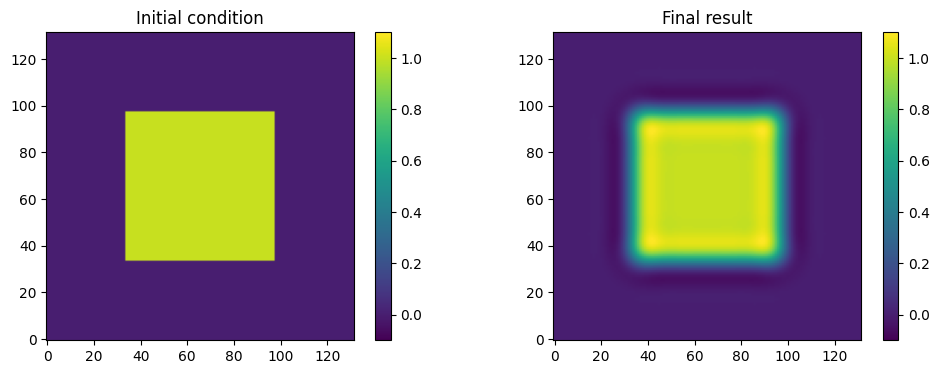

In [85]:
validate_results()

In [100]:
nx_len=2**10
ny_len=2**10

In [101]:
%%bash -s "$nx_len" "$ny_len"
nx_len=$1
ny_len=$2
echo "nx_len = $nx_len, ny_len = $ny_len"

THREADS_LIST="1,4,8,9,18,32,36,72,288"
NODES_LIST="288,72,36,32,16,9,8,4,1"

if [[ -z "${THREADS_LIST// }" ]]; then
  THREADS_LIST=$(seq 5 20)   # por defecto consecutivos
else
  # Reemplazar comas por espacios
  THREADS_LIST=$(echo "$THREADS_LIST" | tr ',' ' ')
fi

if [[ -z "${NODES_LIST// }" ]]; then
  NODES_LIST=$(seq 5 20)   # por defecto consecutivos
else
  # Reemplazar comas por espacios
  NODES_LIST=$(echo "$NODES_LIST" | tr ',' ' ')
fi


file_name="perf"

out_file="experiments/out_${nx_len}_${ny_len}_${file_name}.txt"
dims_file="experiments/dims_${nx_len}_${ny_len}_${file_name}.txt"

if [[ $(hostname -s) == eiger-* ]]; then
  out_file="experiments/out_eiger_${nx_len}_${ny_len}_${file_name}.txt"
  dims_file="experiments/dims_eiger_${nx_len}_${ny_len}_${file_name}.txt"
fi

if [ ! -f "$out_file" ]; then
  echo "runtimes = [[[0.0]*73 for _ in range(73)]for _ in range(20)]" > "$out_file"
fi

if [ ! -f "$dims_file" ]; then
  echo "dimensions = [[[0.0]*73 for _ in range(73)]for _ in range(20)]" > "$dims_file"
fi
HINT="--hint=nomultithread"
BIND="--cpu-bind=cores"
for iteration in  1; do

    for nthreads in $THREADS_LIST; do
        export OMP_NUM_THREADS=$nthreads
    
        for nnodes in $NODES_LIST; do
            if (( nthreads * nnodes == 288)); then

                echo "Running with $nthreads threads and $nnodes MPI tasks"
                rank_file="OMP${nthreads}_MPI${nnodes}_${file_name}_x_nx${nx_len}_ny${ny_len}"
                
                if [[ $(hostname -s) == eiger-* ]]; then
                    output=$(uenv run prgenv-gnu/24.11:v2 --view=default -- srun --ntasks=$nnodes --ntasks-per-node=$nnodes --cpus-per-task=$nthreads ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
                else    
                    # output=$(srun --ntasks=$nnodes --cpus-per-task=$nthreads ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
                    output=$(srun -N1 --ntasks=$nnodes --cpus-per-task=$nthreads ${HINT} ${BIND} --cpu-bind=verbose \
                     --bind-to core --map-by core  
                     ./perf_wrap.sh -n $rank_file ./stencil2d-kparallel_mpi.x --nx $nx_len --ny $ny_len --nz 64 --num_iter 1024)
                fi    
                data_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\d.E+-]+\]')
                runtime=$(echo "$data_line" | sed 's/.*\[//' | sed 's/\]//' | cut -d',' -f6 | xargs)
            
                dims_line=$(echo "$output" | grep -oP '\[\s*\d+,\s*\d+\]' | head -n1)
                nx=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f1 | xargs)
                ny=$(echo "$dims_line" | sed 's/[][]//g' | cut -d',' -f2 | xargs)
            
                # Update or append runtime
                if grep -q "runtimes\[$iteration\]\[$nthreads\]\[$nnodes\]" "$out_file"; then
                    sed -i "s/runtimes\[$iteration\]\[$nthreads\]\[$nnodes\] = .*/runtimes[$iteration][$nthreads][$nnodes] = $runtime/" "$out_file"
                else
                    echo "runtimes[$iteration][$nthreads][$nnodes] = $runtime" >> "$out_file"
                fi
            
                # Update or append dimensions
                if grep -q "dimensions\[$nthreads\]\[$nnodes\]" "$dims_file"; then
                    sed -i "s/dimensions\[$nthreads\]\[$nnodes\] = .*/dimensions[$nthreads][$nnodes] = [$nx, $ny]/" "$dims_file"
                else
                    echo "dimensions[$nthreads][$nnodes] = [$nx, $ny]" >> "$dims_file"
                fi
             
            fi
        done
    done
done

nx_len = 1024, ny_len = 1024
Running with 1 threads and 288 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 4 threads and 72 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 8 threads and 36 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 9 threads and 32 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 18 threads and 16 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 32 threads and 9 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 36 threads and 8 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 72 threads and 4 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


Running with 288 threads and 1 MPI tasks


srun: unrecognized option '--bind-to'
Try "srun --help" for more information


In [102]:
from pathlib import Path
import re
import pandas as pd

# ========================= User configuration =========================
# Folder that contains the perf .txt files (change this to your folder)
DATA_DIR = Path('./perf/')   # e.g., Path("/path/to/perf/outputs")
FILE_GLOB = "*.txt"            # pattern of files to parse
OUTPUT_CSV = "perf_metrics_summary.csv"
# =====================================================================

# ------------------------- Helper functions ---------------------------
# NOTE: Regex patterns for extracting metrics from file content
METRIC_PATTERNS = {
    "mem_access_rd":      re.compile(r"([\d,]+)\s+mem_access_rd(?::[a-z])?\b", re.IGNORECASE),
    "mem_access_wr":      re.compile(r"([\d,]+)\s+mem_access_wr(?::[a-z])?\b", re.IGNORECASE),
    "LLC-load-misses":    re.compile(r"([\d,]+)\s+LLC-load-misses\b", re.IGNORECASE),
    "FP_SCALE_OPS_SPEC":  re.compile(r"([\d,]+)\s+FP_SCALE_OPS_SPEC\b", re.IGNORECASE),
    "FP_FIXED_OPS_SPEC":  re.compile(r"([\d,]+)\s+FP_FIXED_OPS_SPEC\b", re.IGNORECASE),
    "seconds time elapsed": re.compile(r"([\d.,]+)\s+seconds time elapsed\b", re.IGNORECASE),
}

def _to_number(s: str):
    """Convert a string with commas or decimals into int or float."""
    if s is None:
        return None
    s = s.replace(",", "")
    return float(s) if "." in s else int(s)

def parse_perf_file(path: Path) -> dict:
    """Parse one perf .txt file and return metrics as dict."""
    text = path.read_text(errors="ignore")
    result = {}
    for metric, pattern in METRIC_PATTERNS.items():
        m = pattern.search(text)
        value = _to_number(m.group(1)) if m else None
        result[metric] = value
    return result

def parse_filename_info(filename: str) -> dict:
    """
    Extract configuration info (OMP, MPI, nx, ny) from filename.
    Example: OMP12_MPI4_perf_x_nx512_ny512.txt
    """
    info = {}
    m = re.search(r"OMP(\d+)", filename, re.IGNORECASE)
    info["OMP"] = int(m.group(1)) if m else None
    
    m = re.search(r"MPI(\d+)", filename, re.IGNORECASE)
    info["MPI"] = int(m.group(1)) if m else None
    
    m = re.search(r"nx(\d+)", filename, re.IGNORECASE)
    info["nx"] = int(m.group(1)) if m else None
    
    m = re.search(r"ny(\d+)", filename, re.IGNORECASE)
    info["ny"] = int(m.group(1)) if m else None
    
    return info

# --------------------------- Main routine -----------------------------
files = sorted(DATA_DIR.glob(FILE_GLOB))
if not files:
    raise FileNotFoundError(f"No files matched {FILE_GLOB} in {DATA_DIR.resolve()}")

rows = []
index = []
for f in files:
    metrics = parse_perf_file(f)
    config = parse_filename_info(f.name)
    metrics.update(config)  # add OMP, MPI, nx, ny
    rows.append(metrics)
    index.append(f.stem)  # row name

df = pd.DataFrame(rows, index=index)

# Reorder columns to requested order + config info
ordered_cols = [
    "OMP", "MPI", "nx", "ny",
    "mem_access_rd",
    "mem_access_wr",
    "LLC-load-misses",
    "seconds time elapsed",
    "FP_SCALE_OPS_SPEC",
    "FP_FIXED_OPS_SPEC",
]
df = df.reindex(columns=ordered_cols)

# ---------------------- Derived metrics ----------------------
# Assumptions and notes:
#   * total_dram_accesses_per_core_in_Bytes = LLC-load-misses * 64 (bytes per cache line)
#   * total_mem_accesses_per_core_in_Bytes = (mem_access_rd + mem_access_wr) * 4 (bytes per access)
#   * flops = FP_SCALE_OPS_SPEC + FP_FIXED_OPS_SPEC
#   * runtime = seconds time elapsed
#   * Gbytes_moved = total_dram_accesses_per_core_in_Bytes * 72 / 1e9 (as requested)
#   * performance = flops / runtime
#   * intensity = flops / bytes_moved    (bytes_moved introduced below for convenience)

# Ensure numeric dtype for vectorized operations (keep NaN if missing)
for c in ["mem_access_rd", "mem_access_wr", "LLC-load-misses",
          "FP_SCALE_OPS_SPEC", "FP_FIXED_OPS_SPEC", "seconds time elapsed"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Base derived columns
df["total_dram_accesses_per_core_in_Bytes"] = df["LLC-load-misses"] * 64.0
df["total_mem_accesses_per_core_in_Bytes"] = (df["mem_access_rd"] + df["mem_access_wr"]) * 4.0
df["flops"] = df["FP_SCALE_OPS_SPEC"] + df["FP_FIXED_OPS_SPEC"]
df["runtime"] = df["seconds time elapsed"]

# Bytes moved (introduced to compute 'intensidad'); also compute GBytes as requested
df["bytes_moved"]  = df["total_dram_accesses_per_core_in_Bytes"] * 72.0

df["Gflops"] = df["flops"] / 1e9
df["Gbytes_moved"] = df["bytes_moved"] / 1e9

# Performance and intensity (avoid division by zero)
df["performance"] = np.where(df["runtime"] > 0, df["Gflops"] / df["runtime"], np.nan)
df["intensity"] = np.where(df["bytes_moved"] > 0, df["Gflops"] / df["Gbytes_moved"], np.nan)

# Move the derived columns to the end explicitly (already appended at end by creation order).
derived_cols = [
    "total_dram_accesses_per_core_in_Bytes",
    "total_mem_accesses_per_core_in_Bytes",
    "runtime",
    "Gflops",
    "Gbytes_moved",
    "performance",
    "intensity",
]
df = df[[*ordered_cols, *derived_cols]]

# Save and show
df.to_csv(OUTPUT_CSV, index=True)
display(df)
print(f"\nSaved matrix to: {OUTPUT_CSV}")
print(f"Parsed {len(files)} files from: {DATA_DIR.resolve()}")



,OMP,MPI,nx,ny,mem_access_rd,mem_access_wr,LLC-load-misses,seconds time elapsed,FP_SCALE_OPS_SPEC,FP_FIXED_OPS_SPEC,total_dram_accesses_per_core_in_Bytes,total_mem_accesses_per_core_in_Bytes,runtime,Gflops,Gbytes_moved,performance,intensity
OMP18_MPI16_perf_x_nx1024_ny1024,18,16,1024,1024,201545959084,35936357971,9475622133,7.916772,1346516656,826370586541,6.064398e+11,9.499293e+11,7.916772,827.717103,43663.666789,104.552350,0.018957
OMP18_MPI16_perf_x_nx16_ny16,18,16,16,16,1327748988,42184281,3045054,0.045313,23868096,215900471,1.948835e+08,5.479733e+09,0.045313,0.239769,14.031609,5.291353,0.017088
OMP18_MPI16_perf_x_nx256_ny256,18,16,256,256,19071418722,2517814984,36936536,0.605698,338689640,51779939637,2.363938e+09,8.635693e+10,0.605698,52.118629,170.203558,86.047238,0.306214
OMP18_MPI16_perf_x_nx512_ny512,18,16,512,512,57257325043,9339825489,85023787,1.948617,674617436,206747170713,5.441522e+09,2.663886e+11,1.948617,207.421788,391.789610,106.445659,0.529421
OMP18_MPI16_perf_x_nx64_ny64,18,16,64,64,5543117121,234054815,21894143,0.119620,86708164,3277537912,1.401225e+09,2.310869e+10,0.119620,3.364246,100.888211,28.124532,0.033346
OMP1_MPI288_perf_x_nx1024_ny1024,1,288,1024,1024,192648397599,35933044267,6217773928,37.808634,1346365576,826300100264,3.979375e+11,9.143258e+11,37.808634,827.646466,28651.502260,21.890409,0.028887
OMP1_MPI288_perf_x_nx16_ny16,1,288,16,16,121534205,39037913,58432,0.046732,23640448,212711766,3.739648e+06,6.422885e+08,0.046732,0.236352,0.269255,5.057618,0.877802
OMP1_MPI288_perf_x_nx256_ny256,1,288,256,256,12682560459,2514450960,11269989,3.078021,338542408,51773390315,7.212793e+08,6.078805e+10,3.078021,52.111933,51.932109,16.930335,1.003463
OMP1_MPI288_perf_x_nx512_ny512,1,288,512,512,49004794200,9336237993,60107367,11.157327,674467020,206732322512,3.846871e+09,2.333641e+11,11.157327,207.406790,276.974747,18.589291,0.748829
OMP1_MPI288_perf_x_nx64_ny64,1,288,64,64,970601598,231197894,129336,0.230953,86600920,3275972181,8.277504e+06,4.807198e+09,0.230953,3.362573,0.595980,14.559529,5.642088



Saved matrix to: perf_metrics_summary.csv
Parsed 45 files from: /users/class179/HPC4WC_proj5/perf


In [103]:
import matplotlib.pyplot as plt

AGG_CSV  = "group_stats_summary.csv"

# Santis CPU (Grace) ceilings — per node (adjust if needed)
N_GRACE_PER_NODE = 4               # number of Grace CPUs per node you want to model
BW_PER_GRACE_CPU = 512e9           # bytes/s per Grace CPU (LPDDR5X)
PEAK_FP64_PER_GRACE_CPU = 3.960576e12  # flop/s per Grace CPU (approx.)


# ------------------------- Group stats (nx, ny) -----------------------
agg = (df.groupby(["nx", "ny"], dropna=False)
         .agg(intensity_mean=("intensity", "mean"),
              intensity_min =("intensity", "min"),
              intensity_max =("intensity", "max"),
              perf_mean      =("performance", "mean"),
              perf_min       =("performance", "min"),
              perf_max       =("performance", "max"),
              n=("performance", "count"))
         .reset_index())

agg.to_csv(AGG_CSV, index=False)
print(f"Saved group stats -> {AGG_CSV}")


Saved group stats -> group_stats_summary.csv


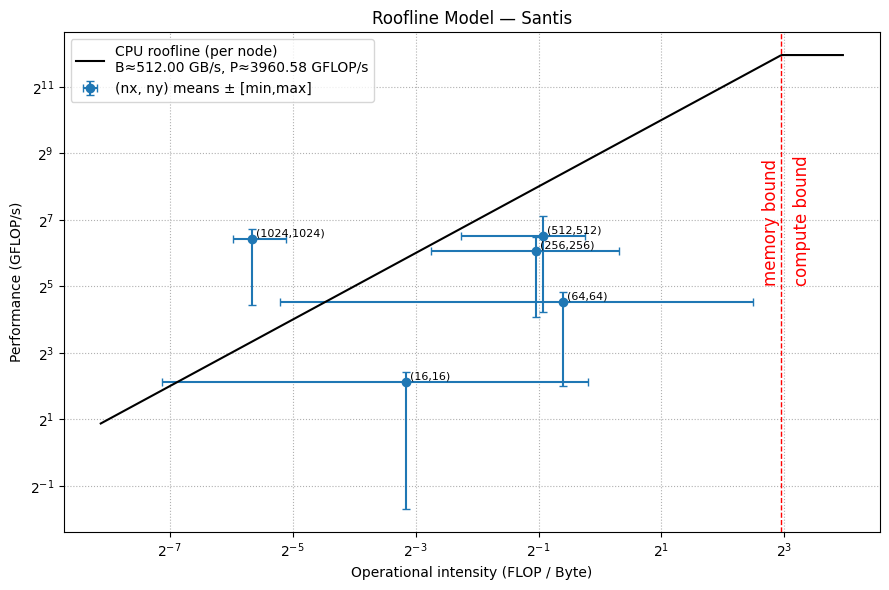

Saved roofline plot -> roofline_santis.png
Ridge intensity ≈ 7.74 FLOP/Byte;  B≈512.00 GB/s,  P≈3960.58 GFLOP/s


In [107]:
import matplotlib.pyplot as plt

PLOT_PNG = "roofline_santis.png"

# --------------------------- Roofline setup ---------------------------
B_CPU = BW_PER_GRACE_CPU              # bytes/s
P_CPU = PEAK_FP64_PER_GRACE_CPU       # flop/s
ridge_x = P_CPU / B_CPU               # FLOP/Byte at ridge

# x-range using observed intensities and ridge
obs_min = agg["intensity_min"].replace([np.inf, -np.inf], np.nan).min()
obs_max = agg["intensity_max"].replace([np.inf, -np.inf], np.nan).max()
if not np.isfinite(obs_min) or obs_min <= 0: obs_min = 1e-6
if not np.isfinite(obs_max) or obs_max <= 0: obs_max = 10.0

x_min = min(obs_min, ridge_x) * 0.5
x_max = max(obs_max, ridge_x) * 2.0
xs = np.logspace(np.log10(x_min), np.log10(x_max), 512)

# Roofline curve in GFLOP/s (divide by 1e9)
roof_cpu_gflops = np.minimum(P_CPU, B_CPU * xs) / 1e9
P_CPU_GF = P_CPU / 1e9  # GFLOP/s for legend

# ------------------------------- Plot --------------------------------
plt.figure(figsize=(9, 6))

# Convert grouped performance from FLOP/s to GFLOP/s for plotting
y_mean_gf = agg["perf_mean"].to_numpy()
y_min_gf  = agg["perf_min"].to_numpy()
y_max_gf  = agg["perf_max"].to_numpy()
yerr = np.vstack([y_mean_gf - y_min_gf, y_max_gf - y_mean_gf]).astype(float)
yerr = np.nan_to_num(yerr, nan=0.0, posinf=0.0, neginf=0.0)

# X remains intensity (FLOP/Byte); use asymmetric error bars
x = agg["intensity_mean"].to_numpy()
xerr = np.vstack([agg["intensity_mean"] - agg["intensity_min"],
                  agg["intensity_max"] - agg["intensity_mean"]]).astype(float)
xerr = np.nan_to_num(xerr, nan=0.0, posinf=0.0, neginf=0.0)

plt.errorbar(x, y_mean_gf, xerr=xerr, yerr=yerr, fmt='o', capsize=3,
            label="(nx, ny) means ± [min,max]")

# Roofline (CPU) in GFLOP/s
plt.plot(xs, roof_cpu_gflops, linewidth=1.5, color = "black",
         label=f"CPU roofline (per node)\nB≈{B_CPU/1e9:.2f} GB/s, P≈{P_CPU_GF:.2f} GFLOP/s")

# Ridge marker (x only; y value is roof at ridge)
plt.axvline(ridge_x, linestyle='--', linewidth=1, color = "red")
# Interpolate y for label
y_ridge = np.interp(ridge_x, xs, roof_cpu_gflops)
#plt.text(ridge_x, y_ridge, " ridge", rotation=90, va='bottom', ha='left')

# Axes, labels, style
plt.xscale('log', base=2); plt.yscale('log', base=2)
plt.xlabel("Operational intensity (FLOP / Byte)")
plt.ylabel("Performance (GFLOP/s)")
plt.title("Roofline Model — Santis")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()

plt.text(ridge_x-1.5, 2**5, 'memory bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')
plt.text(ridge_x+1.05, 2**5, 'compute bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')

for _, r in agg.iterrows():
    if np.isfinite(r["intensity_mean"]) and np.isfinite(r["perf_mean"]):
        nx_val = int(r["nx"]) if pd.notna(r["nx"]) else "NA"
        ny_val = int(r["ny"]) if pd.notna(r["ny"]) else "NA"
        xm = float(r["intensity_mean"])
        ym = float(r["perf_mean"])
        # small multiplicative offset for log scales
        plt.annotate(f"({nx_val},{ny_val})", xy=(xm, ym),
                     xytext=(xm*1.05, ym*1.05), textcoords='data',
                     fontsize=8)

plt.savefig(PLOT_PNG, dpi=200)
plt.show()

print(f"Saved roofline plot -> {PLOT_PNG}")
print(f"Ridge intensity ≈ {ridge_x:.3g} FLOP/Byte;  B≈{B_CPU/1e9:.2f} GB/s,  P≈{P_CPU_GF:.2f} GFLOP/s")

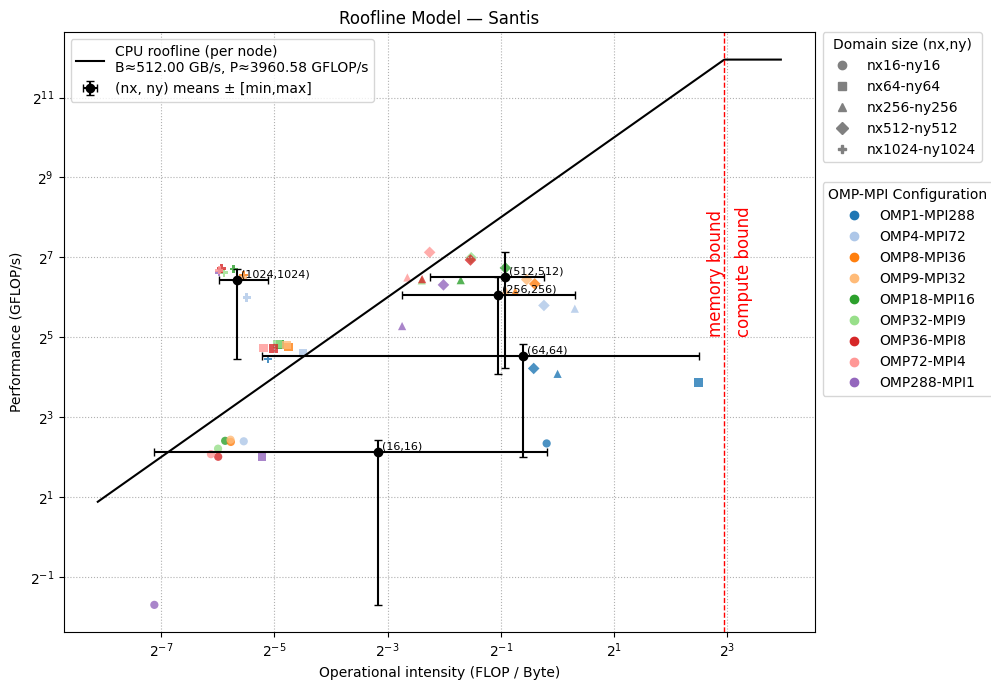

Saved roofline plot -> roofline_santis_v2.png
Ridge intensity ≈ 7.74 FLOP/Byte;  B≈512.00 GB/s,  P≈3960.58 GFLOP/s


In [130]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

PLOT_PNG = "roofline_santis_v2.png"

# --------------------------- Roofline setup ---------------------------
B_CPU = BW_PER_GRACE_CPU              # bytes/s
P_CPU = PEAK_FP64_PER_GRACE_CPU       # flop/s
ridge_x = P_CPU / B_CPU               # FLOP/Byte at ridge

# x-range using observed intensities and ridge
obs_min = agg["intensity_min"].replace([np.inf, -np.inf], np.nan).min()
obs_max = agg["intensity_max"].replace([np.inf, -np.inf], np.nan).max()
if not np.isfinite(obs_min) or obs_min <= 0: obs_min = 1e-6
if not np.isfinite(obs_max) or obs_max <= 0: obs_max = 10.0

x_min = min(obs_min, ridge_x) * 0.5
x_max = max(obs_max, ridge_x) * 2.0
xs = np.logspace(np.log10(x_min), np.log10(x_max), 512)

# Roofline curve in GFLOP/s (divide by 1e9)
roof_cpu_gflops = np.minimum(P_CPU, B_CPU * xs) / 1e9
P_CPU_GF = P_CPU / 1e9  # GFLOP/s for legend

# ---------------------- Color & marker mappings ----------------------
# Colors by (OMP, MPI) combination
uniq_omp_mpi = (df[["OMP", "MPI"]]
                .dropna()
                .astype(int)
                .drop_duplicates()
                .sort_values(["OMP", "MPI"])
                .itertuples(index=False, name=None))
uniq_omp_mpi = list(uniq_omp_mpi)

# Use a large qualitative palette (tab20). Cycle if more combos appear.
palette = list(plt.cm.tab20.colors)
color_map = {combo: palette[i % len(palette)] for i, combo in enumerate(uniq_omp_mpi)}

# Markers by (nx, ny) domain
uniq_domains = (df[["nx", "ny"]]
                .dropna()
                .astype(int)
                .drop_duplicates()
                .sort_values(["nx", "ny"])
                .itertuples(index=False, name=None))
uniq_domains = list(uniq_domains)

markers = ['o','s','^','D','P','X','v','<','>','h','H','*','p','8','d','1','2','3','4','|','_']
marker_map = {dom: markers[i % len(markers)] for i, dom in enumerate(uniq_domains)}


# ------------------------------- Plot --------------------------------
plt.figure(figsize=(10, 7))

# Convert grouped performance from FLOP/s to GFLOP/s for plotting
y_mean_gf = agg["perf_mean"].to_numpy()
y_min_gf  = agg["perf_min"].to_numpy()
y_max_gf  = agg["perf_max"].to_numpy()
yerr = np.vstack([y_mean_gf - y_min_gf, y_max_gf - y_mean_gf]).astype(float)
yerr = np.nan_to_num(yerr, nan=0.0, posinf=0.0, neginf=0.0)

# X remains intensity (FLOP/Byte); use asymmetric error bars
x = agg["intensity_mean"].to_numpy()
xerr = np.vstack([agg["intensity_mean"] - agg["intensity_min"],
                  agg["intensity_max"] - agg["intensity_mean"]]).astype(float)
xerr = np.nan_to_num(xerr, nan=0.0, posinf=0.0, neginf=0.0)

plt.errorbar(x, y_mean_gf, xerr=xerr, yerr=yerr, fmt='o', capsize=3, color = "black",
            label="(nx, ny) means ± [min,max]")

# Annotate each mean point with "(nx,ny)"
for _, r in agg.iterrows():
    if np.isfinite(r["intensity_mean"]) and np.isfinite(r["perf_mean"]):
        nx_val = int(r["nx"]) if pd.notna(r["nx"]) else "NA"
        ny_val = int(r["ny"]) if pd.notna(r["ny"]) else "NA"
        xm = float(r["intensity_mean"])
        ym = float(r["perf_mean"])
        # small multiplicative offset for log scales
        plt.annotate(f"({nx_val},{ny_val})", xy=(xm, ym),
                     xytext=(xm*1.05, ym*1.05), textcoords='data',
                     fontsize=8)

# Plot individual runs with color by (OMP,MPI) and marker by (nx,ny)
for _, r in df.iterrows():
    if not (pd.notna(r["intensity"]) and pd.notna(r["performance"])
            and pd.notna(r["OMP"]) and pd.notna(r["MPI"])
            and pd.notna(r["nx"])  and pd.notna(r["ny"])):
        continue
    combo = (int(r["OMP"]), int(r["MPI"]))
    dom   = (int(r["nx"]),  int(r["ny"]))
    plt.scatter(r["intensity"], r["performance"],
                marker=marker_map.get(dom, 'o'),
                s=35, alpha=0.8,
                color=color_map.get(combo, 'C0'),
                edgecolors='none')

# Roofline (CPU) in GFLOP/s
plt.plot(xs, roof_cpu_gflops, linewidth=1.5, color = "black",
         label=f"CPU roofline (per node)\nB≈{B_CPU/1e9:.2f} GB/s, P≈{P_CPU_GF:.2f} GFLOP/s")

# Ridge marker (x only; y value is roof at ridge)
plt.axvline(ridge_x, linestyle='--', linewidth=1, color = "red")
# Interpolate y for label
y_ridge = np.interp(ridge_x, xs, roof_cpu_gflops)
#plt.text(ridge_x, y_ridge, " ridge", rotation=90, va='bottom', ha='left')

# Axes, labels, style
plt.xscale('log', base=2); plt.yscale('log', base=2)
plt.xlabel("Operational intensity (FLOP / Byte)")
plt.ylabel("Performance (GFLOP/s)")
plt.title("Roofline Model — Santis")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()

ax = plt.gca()

# Make room on the right for outside legends
plt.subplots_adjust(right=0.82)  # tweak 0.70–0.82 if needed

# 1) Main legend (keep inside the axes, or wherever you like)
main_handles, main_labels = ax.get_legend_handles_labels()
main_legend = ax.legend(main_handles, main_labels, loc="upper left", frameon=True)
ax.add_artist(main_legend)  # keep it when adding more legends

# 2) Color legend (OMP–MPI) — top-right, OUTSIDE
leg_colors = ax.legend(
    handles=color_handles,
    title="OMP-MPI Configuration",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.75),   # (x, y) in axes coords; x>1 puts it outside to the right
    borderaxespad=0.0,
    frameon=True
)
ax.add_artist(leg_colors)

# 3) Marker legend (domain nx,ny) — below the previous one, OUTSIDE
leg_markers = ax.legend(
    handles=marker_handles,
    title="Domain size (nx,ny)",
    loc="upper left",
    bbox_to_anchor=(1.01, 1.00),   # lower y so it sits underneath, adjust 0.55→0.50 as needed
    borderaxespad=0.0,
    frameon=True
)

plt.text(ridge_x-1.5, 2**5, 'memory bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')
plt.text(ridge_x+1.05, 2**5, 'compute bound', color='red', fontsize=12, rotation=90, va='bottom', ha='left')

plt.savefig(PLOT_PNG, dpi=200)
plt.show()

print(f"Saved roofline plot -> {PLOT_PNG}")
print(f"Ridge intensity ≈ {ridge_x:.3g} FLOP/Byte;  B≈{B_CPU/1e9:.2f} GB/s,  P≈{P_CPU_GF:.2f} GFLOP/s")